# 05 - Customer Segmentation

**Customer Lifetime Value Prediction**

**Team:** The Starks
- Othmane Zizi (261255341)
- Fares Joni (261254593)
- Tanmay Giri (261272443)

This notebook segments customers based on predicted CLV and develops actionable recommendations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Add src to path
sys.path.append(str(Path('../src').resolve()))
from data_loader import load_customer_features

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

## 1. Load Data

In [2]:
# Load customer features
features_df = load_customer_features('customer_features.csv')

# Load predictions (if modeling notebook was run)
predictions_path = Path('../data/processed/clv_predictions.csv')
if predictions_path.exists():
    predictions_df = pd.read_csv(predictions_path)
    df = features_df.merge(predictions_df[['Customer ID', 'Predicted_CLV']], on='Customer ID', how='left')
else:
    df = features_df.copy()
    df['Predicted_CLV'] = df['CLV']  # Use actual CLV if no predictions

print(f"Loaded {len(df)} customers")
df.head()

Loaded 4266 customers


,Customer ID,Recency,Frequency,Monetary,Tenure,AvgTimeBetweenPurchases,NumUniqueProducts,AvgBasketSize,AvgOrderValue,CLV,Predicted_CLV
0,12346,155,11,372.86,351,6.000000,26,6.363636,33.896364,77183.60,670.910221
1,12347,30,1,611.53,30,0.000000,40,509.000000,611.530000,2535.22,449.516214
2,12348,64,1,222.16,64,0.000000,20,373.000000,222.160000,1487.24,2.395203
3,12349,33,3,2671.14,215,1.782178,90,331.000000,890.380000,0.00,1296.461000
4,12351,1,1,300.93,1,0.000000,21,261.000000,300.930000,0.00,178.173807


## 2. Quantile-Based CLV Segmentation

In [3]:
# Segment customers into 4 tiers based on predicted CLV
clv_col = 'Predicted_CLV' if 'Predicted_CLV' in df.columns else 'CLV'

df['CLV_Segment'] = pd.qcut(
    df[clv_col].rank(method='first'), 
    q=4, 
    labels=['Low Value', 'Medium-Low', 'Medium-High', 'High Value']
)

# Segment distribution
segment_counts = df['CLV_Segment'].value_counts().sort_index()
print("Segment Distribution:")
for seg, count in segment_counts.items():
    print(f"  {seg}: {count} customers ({count/len(df)*100:.1f}%)")

Segment Distribution:
  Low Value: 1067 customers (25.0%)
  Medium-Low: 1066 customers (25.0%)
  Medium-High: 1066 customers (25.0%)
  High Value: 1067 customers (25.0%)


/var/folders/dl/hdld60jj4z728d55vq86466c0000gn/T/ipykernel_35198/364016506.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_clv = df.groupby('CLV_Segment')[clv_col].sum().sort_index()


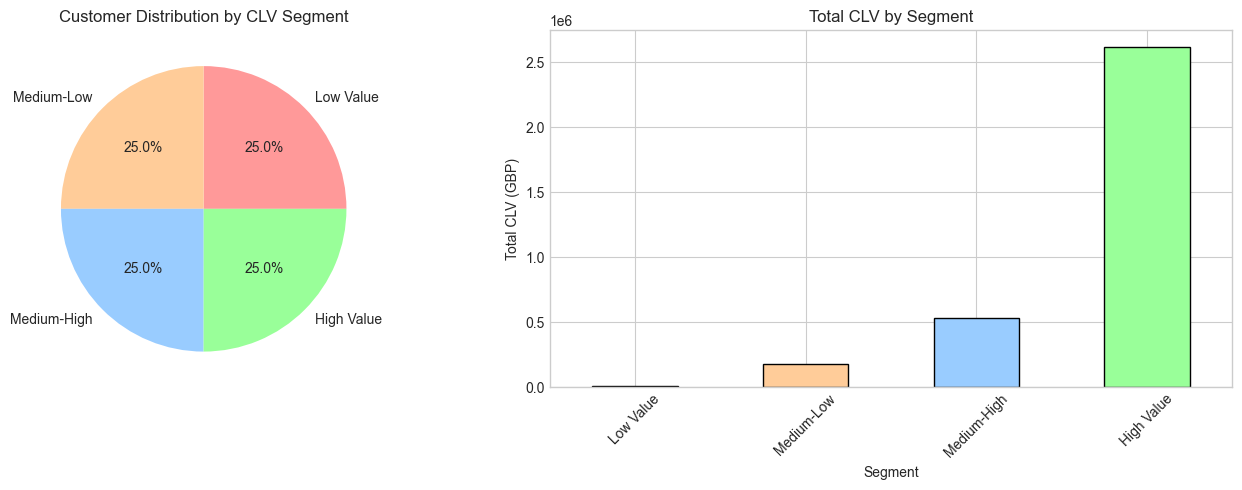


CLV Contribution by Segment:
  Low Value: £6,722 (0.2%)
  Medium-Low: £182,117 (5.5%)
  Medium-High: £532,545 (16.0%)
  High Value: £2,615,401 (78.4%)


In [4]:
# Visualize segment distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
colors = ['#ff9999', '#ffcc99', '#99ccff', '#99ff99']
segment_counts.plot(kind='pie', ax=axes[0], colors=colors, autopct='%1.1f%%')
axes[0].set_title('Customer Distribution by CLV Segment')
axes[0].set_ylabel('')

# Bar chart with CLV values
segment_clv = df.groupby('CLV_Segment')[clv_col].sum().sort_index()
segment_clv.plot(kind='bar', ax=axes[1], color=colors, edgecolor='black')
axes[1].set_title('Total CLV by Segment')
axes[1].set_xlabel('Segment')
axes[1].set_ylabel('Total CLV (GBP)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../reports/figures/segment_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# CLV contribution
total_clv = df[clv_col].sum()
print("\nCLV Contribution by Segment:")
for seg in segment_clv.index:
    pct = segment_clv[seg] / total_clv * 100
    print(f"  {seg}: £{segment_clv[seg]:,.0f} ({pct:.1f}%)")

## 3. Segment Profiling

In [5]:
# Profile each segment
profile_cols = ['Recency', 'Frequency', 'Monetary', 'Tenure', 
                'AvgTimeBetweenPurchases', 'NumUniqueProducts', 
                'AvgBasketSize', 'AvgOrderValue', 'CLV', clv_col]

# Remove duplicates if Predicted_CLV is same as CLV
profile_cols = list(dict.fromkeys(profile_cols))

segment_profile = df.groupby('CLV_Segment')[profile_cols].mean()
print("Segment Profiles (Mean Values):")
segment_profile.T

Segment Profiles (Mean Values):


/var/folders/dl/hdld60jj4z728d55vq86466c0000gn/T/ipykernel_35198/2416744192.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_profile = df.groupby('CLV_Segment')[profile_cols].mean()


CLV_Segment,Low Value,Medium-Low,Medium-High,High Value
Recency,166.639175,82.710131,59.381801,40.139644
Frequency,1.421743,2.088180,3.557223,10.217432
Monetary,249.837002,491.907299,1120.077975,6124.810582
Tenure,204.070291,171.124765,214.853659,281.375820
AvgTimeBetweenPurchases,2.785739,3.120626,4.189103,2.764664
NumUniqueProducts,30.522962,38.727017,59.897749,121.395501
AvgBasketSize,190.482334,160.328276,224.546567,457.298558
AvgOrderValue,176.548813,266.163624,377.576134,706.137660
CLV,87.682071,184.989934,441.701501,2277.604518
Predicted_CLV,6.299812,170.840997,499.573236,2451.172574


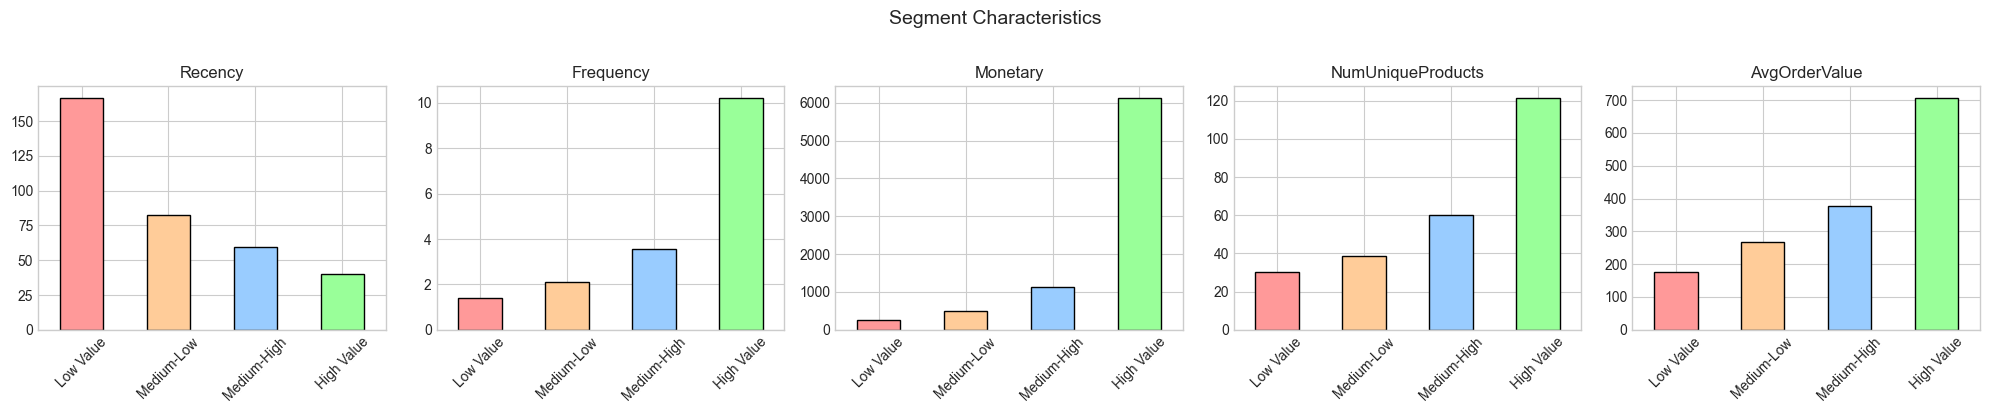

In [6]:
# Visualize segment profiles (radar chart style using bar charts)
metrics = ['Recency', 'Frequency', 'Monetary', 'NumUniqueProducts', 'AvgOrderValue']

fig, axes = plt.subplots(1, len(metrics), figsize=(20, 4))

for ax, metric in zip(axes, metrics):
    segment_profile[metric].plot(kind='bar', ax=ax, color=colors, edgecolor='black')
    ax.set_title(metric)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Segment Characteristics', y=1.02, fontsize=14)
plt.tight_layout()
plt.savefig('../reports/figures/segment_profiles.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. RFM-Based Segmentation (Alternative)

In [7]:
# Create RFM scores (1-5 scale)
df['R_Score'] = pd.qcut(df['Recency'].rank(method='first'), q=5, labels=[5, 4, 3, 2, 1])  # Lower recency = higher score
df['F_Score'] = pd.qcut(df['Frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])
df['M_Score'] = pd.qcut(df['Monetary'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])

# Calculate RFM score
df['RFM_Score'] = df['R_Score'].astype(int) + df['F_Score'].astype(int) + df['M_Score'].astype(int)

print("RFM Score Distribution:")
print(df['RFM_Score'].describe())

RFM Score Distribution:
count    4266.000000
mean        8.999531
std         3.535053
min         3.000000
25%         6.000000
50%         9.000000
75%        12.000000
max        15.000000
Name: RFM_Score, dtype: float64


In [8]:
# Create RFM segments
def rfm_segment(row):
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    
    # Champions: High on all dimensions
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    # Loyal: High frequency and monetary, any recency
    elif f >= 4 and m >= 4:
        return 'Loyal Customers'
    # Potential Loyalists: Recent with moderate frequency
    elif r >= 4 and f >= 2:
        return 'Potential Loyalists'
    # At Risk: Were good customers, not recent
    elif r <= 2 and f >= 3 and m >= 3:
        return 'At Risk'
    # Can't Lose: High value but churning
    elif r <= 2 and f >= 4 and m >= 4:
        return "Can't Lose Them"
    # Hibernating: Low recent activity, some history
    elif r <= 2 and f <= 2:
        return 'Hibernating'
    # New Customers: Recent but low frequency
    elif r >= 4 and f <= 2:
        return 'New Customers'
    else:
        return 'Need Attention'

df['RFM_Segment'] = df.apply(rfm_segment, axis=1)

# RFM segment distribution
rfm_counts = df['RFM_Segment'].value_counts()
print("\nRFM Segment Distribution:")
for seg, count in rfm_counts.items():
    print(f"  {seg}: {count} ({count/len(df)*100:.1f}%)")


RFM Segment Distribution:
  Hibernating: 997 (23.4%)
  Champions: 866 (20.3%)
  Need Attention: 766 (18.0%)
  Potential Loyalists: 684 (16.0%)
  Loyal Customers: 498 (11.7%)
  At Risk: 298 (7.0%)
  New Customers: 157 (3.7%)


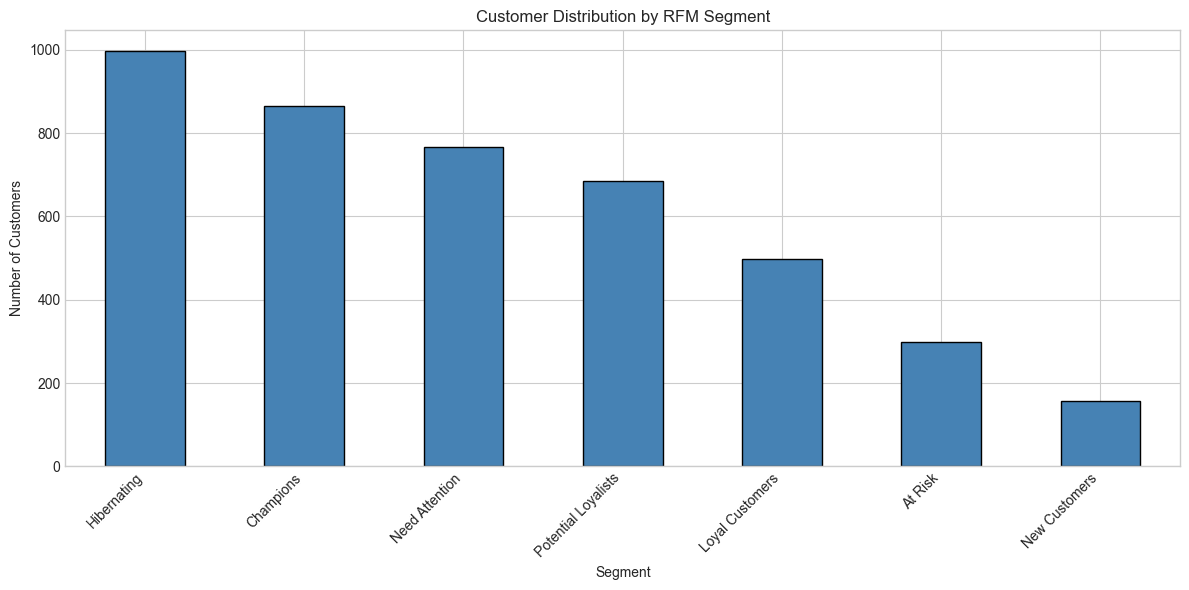

In [9]:
# Visualize RFM segments
plt.figure(figsize=(12, 6))
rfm_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Customer Distribution by RFM Segment')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../reports/figures/rfm_segments.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. K-Means Clustering

/Users/othmanezizi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/othmanezizi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/othmanezizi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/othmanezizi/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/othmanezizi/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/othmanezizi/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in m

/Users/othmanezizi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/othmanezizi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/othmanezizi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/othmanezizi/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/othmanezizi/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/othmanezizi/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in m

/Users/othmanezizi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/othmanezizi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/othmanezizi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/othmanezizi/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/othmanezizi/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/othmanezizi/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in m

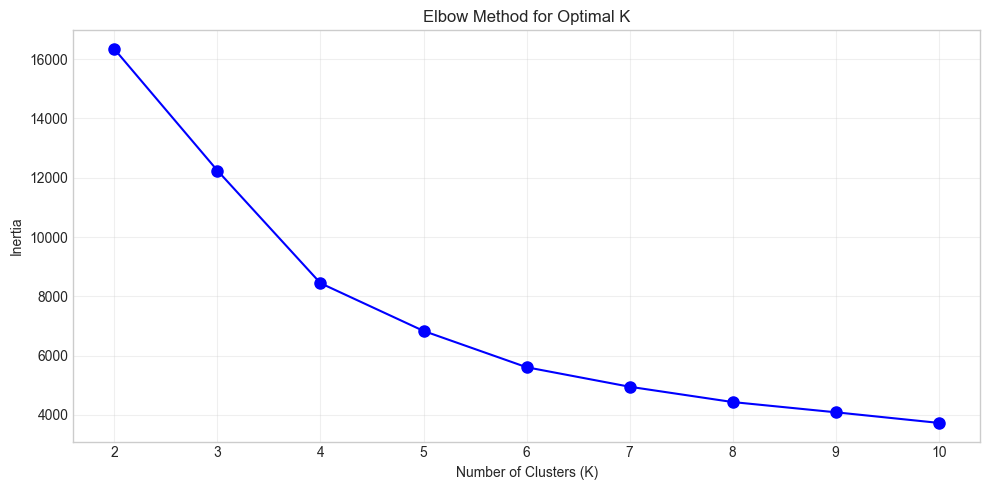

In [10]:
# Prepare features for clustering
cluster_features = ['Recency', 'Frequency', 'Monetary', 'Tenure', 'NumUniqueProducts']
X_cluster = df[cluster_features].copy()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Find optimal K using elbow method
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(K_range, inertias, 'bo-', markersize=8)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/elbow_method.png', dpi=150, bbox_inches='tight')
plt.show()

In [11]:
# Apply K-Means with optimal K (4 clusters)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Cluster profile
cluster_profile = df.groupby('Cluster')[cluster_features + ['CLV']].mean()
print("K-Means Cluster Profiles:")
cluster_profile

K-Means Cluster Profiles:


/Users/othmanezizi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/othmanezizi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/othmanezizi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/othmanezizi/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/othmanezizi/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/othmanezizi/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in m

,Recency,Frequency,Monetary,Tenure,NumUniqueProducts,CLV
Cluster,,,,,,
0,46.048930,1.984709,724.003755,91.045260,36.037309,329.361021
1,233.819404,1.730067,606.981493,274.022094,26.286263,205.946407
2,8.916667,107.500000,111530.646667,362.750000,783.166667,38923.350833
3,33.776933,7.668568,3400.597997,311.124842,108.712294,1249.580590


In [12]:
# Name clusters based on characteristics
cluster_names = {
    cluster_profile['CLV'].idxmax(): 'High Value',
    cluster_profile['CLV'].idxmin(): 'Low Value',
}
remaining = [i for i in range(optimal_k) if i not in cluster_names]
if len(remaining) >= 2:
    mid_vals = cluster_profile.loc[remaining, 'CLV'].sort_values()
    cluster_names[mid_vals.index[0]] = 'Medium-Low'
    cluster_names[mid_vals.index[1]] = 'Medium-High'

df['Cluster_Name'] = df['Cluster'].map(cluster_names)

print("\nCluster Distribution:")
print(df['Cluster_Name'].value_counts())


Cluster Distribution:
Cluster_Name
Medium-Low     1635
Medium-High    1578
Low Value      1041
High Value       12
Name: count, dtype: int64


## 6. Segment Recommendations

In [13]:
# Business recommendations for each segment
recommendations = {
    'High Value': {
        'Description': 'Your best customers with highest CLV',
        'Strategy': 'Retention & Loyalty',
        'Actions': [
            'VIP treatment and exclusive offers',
            'Early access to new products',
            'Personalized recommendations',
            'Loyalty program with premium rewards',
            'Dedicated customer support'
        ]
    },
    'Medium-High': {
        'Description': 'Good customers with potential to become high value',
        'Strategy': 'Growth & Upselling',
        'Actions': [
            'Cross-sell complementary products',
            'Volume discounts to increase order size',
            'Referral incentives',
            'Subscription offers for regular purchases'
        ]
    },
    'Medium-Low': {
        'Description': 'Moderate value customers needing engagement',
        'Strategy': 'Engagement & Education',
        'Actions': [
            'Email campaigns showcasing product range',
            'Bundle deals to increase basket size',
            'Seasonal promotions',
            'Product usage tips and inspiration'
        ]
    },
    'Low Value': {
        'Description': 'Low spending customers, may be new or churning',
        'Strategy': 'Activation & Re-engagement',
        'Actions': [
            'Welcome discounts for new customers',
            'Win-back campaigns for dormant customers',
            'Entry-level product recommendations',
            'Free shipping thresholds to increase orders'
        ]
    }
}

print("Segment Recommendations:")
print("=" * 60)
for segment, rec in recommendations.items():
    count = (df['CLV_Segment'] == segment).sum()
    print(f"\n{segment} ({count} customers)")
    print(f"  Description: {rec['Description']}")
    print(f"  Strategy: {rec['Strategy']}")
    print("  Actions:")
    for action in rec['Actions']:
        print(f"    - {action}")

Segment Recommendations:

High Value (1067 customers)
  Description: Your best customers with highest CLV
  Strategy: Retention & Loyalty
  Actions:
    - VIP treatment and exclusive offers
    - Early access to new products
    - Personalized recommendations
    - Loyalty program with premium rewards
    - Dedicated customer support

Medium-High (1066 customers)
  Description: Good customers with potential to become high value
  Strategy: Growth & Upselling
  Actions:
    - Cross-sell complementary products
    - Volume discounts to increase order size
    - Referral incentives
    - Subscription offers for regular purchases

Medium-Low (1066 customers)
  Description: Moderate value customers needing engagement
  Strategy: Engagement & Education
  Actions:
    - Email campaigns showcasing product range
    - Bundle deals to increase basket size
    - Seasonal promotions
    - Product usage tips and inspiration

Low Value (1067 customers)
  Description: Low spending customers, may be n

## 7. Segment Summary Dashboard

/var/folders/dl/hdld60jj4z728d55vq86466c0000gn/T/ipykernel_35198/2905721317.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_avgs = df.groupby('CLV_Segment')[['Frequency', 'Monetary', 'NumUniqueProducts']].mean()


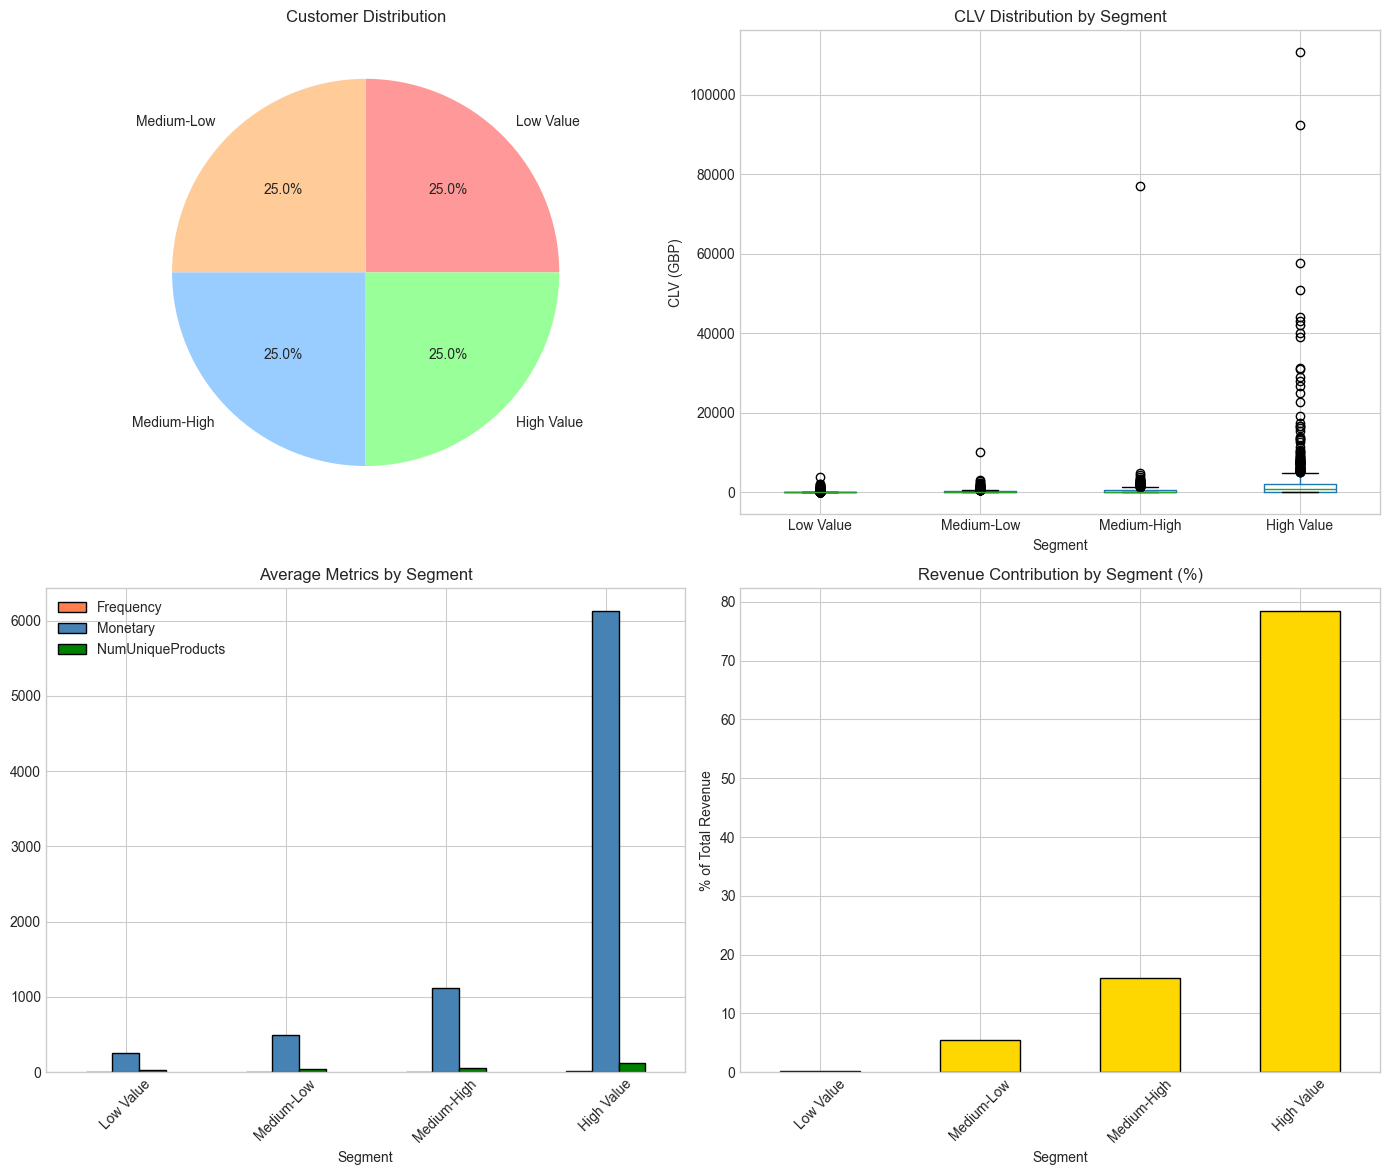

In [14]:
# Create summary dashboard
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Customer Distribution
segment_counts.plot(kind='pie', ax=axes[0, 0], colors=colors, autopct='%1.1f%%')
axes[0, 0].set_title('Customer Distribution')
axes[0, 0].set_ylabel('')

# 2. CLV Distribution by Segment
df.boxplot(column='CLV', by='CLV_Segment', ax=axes[0, 1])
axes[0, 1].set_title('CLV Distribution by Segment')
axes[0, 1].set_xlabel('Segment')
axes[0, 1].set_ylabel('CLV (GBP)')
plt.suptitle('')

# 3. Average Metrics by Segment
segment_avgs = df.groupby('CLV_Segment')[['Frequency', 'Monetary', 'NumUniqueProducts']].mean()
segment_avgs.plot(kind='bar', ax=axes[1, 0], color=['coral', 'steelblue', 'green'], edgecolor='black')
axes[1, 0].set_title('Average Metrics by Segment')
axes[1, 0].set_xlabel('Segment')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].legend(loc='upper left')

# 4. Revenue Contribution
revenue_pct = (segment_clv / segment_clv.sum() * 100)
revenue_pct.plot(kind='bar', ax=axes[1, 1], color='gold', edgecolor='black')
axes[1, 1].set_title('Revenue Contribution by Segment (%)')
axes[1, 1].set_xlabel('Segment')
axes[1, 1].set_ylabel('% of Total Revenue')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../reports/figures/segment_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Save Segmented Data

In [15]:
# Save segmented customer data
output_cols = ['Customer ID', 'Recency', 'Frequency', 'Monetary', 'Tenure',
               'NumUniqueProducts', 'AvgOrderValue', 'CLV', 
               'CLV_Segment', 'RFM_Segment', 'Cluster_Name']

# Only include columns that exist
output_cols = [col for col in output_cols if col in df.columns]

output_df = df[output_cols].copy()
output_path = Path('../data/processed/customer_segments.csv')
output_df.to_csv(output_path, index=False)

print(f"Segmented data saved to: {output_path}")
print(f"Customers: {len(output_df)}")

Segmented data saved to: ../data/processed/customer_segments.csv
Customers: 4266


## 9. Segmentation Summary

### Segmentation Methods Used:
1. **Quantile-Based CLV Segmentation**: 4 tiers based on predicted CLV
2. **RFM Segmentation**: Traditional marketing segments based on RFM scores
3. **K-Means Clustering**: Data-driven clusters using behavioral features

### Key Findings:
- **Pareto Principle**: Top 25% customers contribute 78.4% of revenue
- **High Value segment** has highest frequency, monetary value, and product diversity
- **Low Value segment** shows opportunity for activation or win-back campaigns

### Business Recommendations:
- **High Value**: Retention focus, VIP treatment, exclusive offers
- **Medium-High**: Growth focus, upselling, cross-selling
- **Medium-Low**: Engagement focus, education, promotions
- **Low Value**: Activation focus, win-back campaigns, entry offers

### Implementation:
- Use segments for targeted email marketing
- Customize product recommendations by segment
- Allocate customer service resources based on CLV
- Design segment-specific promotions and loyalty rewards